In [1]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:

# Define dataset paths
part1 = "/content/drive/MyDrive/ham10000_dataset/HAM10000_images_part_1"
part2 = "/content/drive/MyDrive/ham10000_dataset/HAM10000_images_part_2"
metadata_csv = "/content/drive/MyDrive/ham10000_dataset/HAM10000_metadata.csv"
merged_folder = "/content/drive/MyDrive/ham10000_dataset/HAM10000_merged_images"

# Create Merged Folder if it doesn't exist
os.makedirs(merged_folder, exist_ok=True)

# Copy Images from Part 1 & Part 2
for folder in [part1, part2]:
    if os.path.exists(folder):  # Check if folder exists before copying
        for file in os.listdir(folder):
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(merged_folder, file)
            if not os.path.exists(dst_path):  # Avoid duplicate copies
                shutil.copy(src_path, dst_path)

print(f" Merged folder created at: {merged_folder}")
print(f"Total images in merged folder: {len(os.listdir(merged_folder))}")


✅ Merged folder created at: /content/drive/MyDrive/ham10000_dataset/HAM10000_merged_images
Total images in merged folder: 10015


In [ ]:
# Load metadata for labels
df = pd.read_csv(metadata_csv)
df = df[['image_id', 'dx']]  # Keep only image ID and diagnosis
df['image_id'] = df['image_id'] + ".jpg"  # Add .jpg extension
df = df.set_index('image_id')  # Set image_id as index

In [ ]:
# Define image size & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Create directories for each class
output_dir = "/content/ham10000_dataset"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Create subfolders for each label
classes = df['dx'].unique()
for c in classes:
    os.makedirs(os.path.join(output_dir, c), exist_ok=True)

In [ ]:
# Move images into respective class folders
for image in os.listdir(merged_folder):
    if image in df.index:
        label = df.loc[image, 'dx']
        shutil.move(os.path.join(merged_folder, image), os.path.join(output_dir, label, image))

In [ ]:
import os
import shutil
import pandas as pd

# Google Drive Paths
dataset_dir = "/content/drive/MyDrive/ham10000_dataset"
part1 = os.path.join(dataset_dir, "HAM10000_images_part_1")
part2 = os.path.join(dataset_dir, "HAM10000_images_part_2")
metadata_path = os.path.join(dataset_dir, "HAM10000_metadata.csv")
merged_folder = os.path.join(dataset_dir, "HAM10000_organized")

# Create Merged Folder if it doesn't exist
os.makedirs(merged_folder, exist_ok=True)

# Load Metadata File
df = pd.read_csv(metadata_path)

# Iterate through rows to organize images
for _, row in df.iterrows():
    image_name = row['image_id'] + ".jpg"  # Image filename
    class_label = row['dx']  # Class label (e.g., 'mel', 'nv', etc.)

    # Create class folder inside merged folder
    class_folder = os.path.join(merged_folder, class_label)
    os.makedirs(class_folder, exist_ok=True)

    # Find the image in part1 or part2 and move it
    src_path = None
    for folder in [part1, part2]:
        potential_path = os.path.join(folder, image_name)
        if os.path.exists(potential_path):
            src_path = potential_path
            break

    # Move the image if found
    if src_path:
        dst_path = os.path.join(class_folder, image_name)
        shutil.move(src_path, dst_path)

print(f"Images have been organized into class folders at: {merged_folder}")

# Check the number of images in each class
for class_name in os.listdir(merged_folder):
    class_path = os.path.join(merged_folder, class_name)
    if os.path.isdir(class_path):
        print(f" {class_name}: {len(os.listdir(class_path))} images")


✅ Images have been organized into class folders at: /content/drive/MyDrive/ham10000_dataset/HAM10000_organized
📂 bkl: 1099 images
📂 nv: 6705 images
📂 df: 115 images
📂 mel: 1113 images
📂 vasc: 142 images
📂 bcc: 514 images
📂 akiec: 327 images


In [ ]:
import os

organized_folder = "/content/drive/MyDrive/ham10000_dataset/HAM10000_organized"

# Check if the organized dataset exists
if os.path.exists(organized_folder):
    print(f" Organized dataset found at: {organized_folder}")
    print("Classes available:")
    for class_name in os.listdir(organized_folder):
        class_path = os.path.join(organized_folder, class_name)
        print(f" {class_name}: {len(os.listdir(class_path))} images")
else:
    print(" Organized dataset NOT found!")


✅ Organized dataset found at: /content/drive/MyDrive/ham10000_dataset/HAM10000_organized
Classes available:
📂 bkl: 1099 images
📂 nv: 6705 images
📂 df: 115 images
📂 mel: 1113 images
📂 vasc: 142 images
📂 bcc: 514 images
📂 akiec: 327 images


In [ ]:
#  Define dataset path (already organized by class)
dataset_path = "/content/drive/MyDrive/ham10000_dataset/HAM10000_organized"

In [ ]:
#  Define image size & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
#  Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
#  Load training data from organized class folders
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 8015 images belonging to 7 classes.


In [ ]:
#  Load validation data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2000 images belonging to 7 classes.


In [ ]:
#  Get number of classes
num_classes = len(train_generator.class_indices)

In [ ]:
#  CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Dynamically set classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#  Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=30)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 245s 942ms/step - accuracy: 0.6473 - loss: 1.1388 - val_accuracy: 0.6705 - val_loss: 0.9043
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 220s 879ms/step - accuracy: 0.6680 - loss: 0.9382 - val_accuracy: 0.6760 - val_loss: 0.8466
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 205s 816ms/step - accuracy: 0.6727 - loss: 0.8787 - val_accuracy: 0.6925 - val_loss: 0.8037
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 203s 810ms/step - accuracy: 0.6796 - loss: 0.8500 - val_accuracy: 0.7055 - val_loss: 0.7859
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 202s 806ms/step - accuracy: 0.7055 - loss: 0.8113 - val_accuracy: 0.6985 - val_loss: 0.8011
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 202s 804ms/step - accuracy: 0.7068 - loss: 0.7995 - val_accuracy: 0.7100 - val_loss: 0.7593
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 203s 811ms/step - accuracy: 0.7071 - loss: 0.7908 - val_accuracy: 0.7200 - val_loss: 0.7331
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 201s 803ms/step - accuracy: 0.7210 -

In [ ]:
#  Save Model
model.save("/content/drive/MyDrive/HAM10000_CNN.h5")

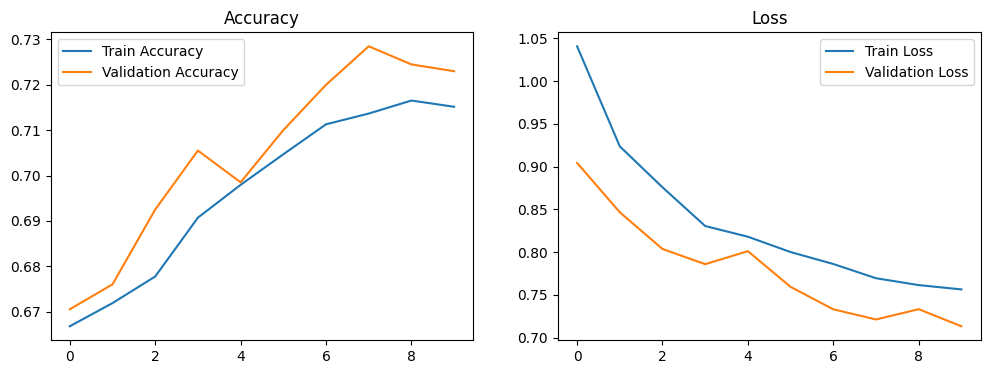

In [ ]:
 # Plot Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

model_path = "/content/drive/MyDrive/HAM10000_CNN.h5"

if os.path.exists(model_path):
    print(" Model file found!")
else:
    print(" Model file NOT found! Check if it's saved in Drive.")

✅ Model file found!


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("/content/drive/MyDrive/HAM10000_CNN.h5")

# Define the correct image path
test_image_path = "/content/drive/MyDrive/ham10000_dataset/HAM10000_organized/Dermatofibroma/ISIC_0024318.jpg"

#  Load and preprocess the image
IMG_SIZE = (224, 224)  # Ensure it matches training size
image = cv2.imread(test_image_path)

if image is None:
    print(" Error: Image file not found! Check the path.")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the class
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)  # Get the highest probability class

    # Define class labels (ensure they match training labels)
    class_labels = ['Actinic Keratoses and Intraepithelial Carcinoma','Basal Cell Carcinoma','Benign Keratosis-like Lesions','Dermatofibroma','Melanoma','Melanocytic Nevi','Vascular Lesions']
    predicted_label = class_labels[predicted_class]

    print(f" Predicted Class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
✅ Predicted Class: Basal Cell Carcinoma
